## 異常検知通し課題
---

#### テーマ

不快指数から、過ごしやすい / 過ごしにくい 地域を検知する

#### 異常検知モデルで検知したい異常

  * 年間における不快な日数と快適な日数の分布に対する外れ度
  * 不快指数は、 "日平均気温" と "日平均相対湿度" から計算  （不快指数の計算：[wikipedia - 不快指数](https://ja.wikipedia.org/wiki/%E4%B8%8D%E5%BF%AB%E6%8C%87%E6%95%B0)）


#### データの整形
---

#### 使用したデータ

対象データ：日平均気温　と　日平均相対湿度  
対象期間：2018/1/1 - 201812/31  
対象地域：日平均気温と日平均相対湿度が取得可能な154地点  
データ元：[気象庁 - 過去の気象データ](https://www.data.jma.go.jp/gmd/risk/obsdl/)   

#### 前処理方法

気象データをDL -> 構造データへ -> 不快指数を計算  
→データクレンジング.ipynb

### 異常検知モデルのアプローチ と データの確認
---

不快かどうかは前日や当日の他地域の状況に依存せず、年間全地域の通しで評価したいので、  
時系列データにせず、一次元のクロスセクションデータとして扱う  
  
正規分布とみなせそうならホテリングのT^2、無理そうならk近傍法を試す方針にする  
→結果的にホテリングのT^2を採用

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime
import folium

In [2]:
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('seaborn')

%matplotlib inline

In [3]:
# データロード
df = pd.read_csv("../data/temperature_humidity_index/processed/location_with_humidity.csv", header=0)

In [4]:
# 日付をyyyymmdd形式へ変換させる
df["ymd"] = pd.to_datetime(df["ymd"], format='%Y/%m/%d')

#### 不快指数のヒストグラムをそのまま取ると、多峰になってしまう

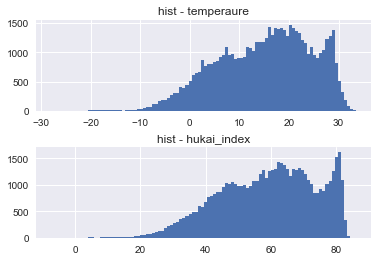

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.4)
axes[0].set_title("hist - temperaure")
axes[1].set_title("hist - hukai_index")
n, bins, patches = axes[0].hist(df["temperature"], bins=100) # 気温
n, bins, patches = axes[1].hist(df["hukai_index"], bins=100) # 不快指数

#### 少なくとも季節によって分布の形状が違う

In [6]:
# 季節性を確認してみるため、分解
df_summer = df[(df["ymd"] >= pd.Timestamp(2018, 6, 1)) & (df["ymd"] <= pd.Timestamp(2018, 8, 31))]
df_winter = df[(df["ymd"] >= pd.Timestamp(2018, 1, 1)) & (df["ymd"] <= pd.Timestamp(2018, 2, 28)) | (df["ymd"] >= pd.Timestamp(2018, 12, 1)) & (df["ymd"] <= pd.Timestamp(2018, 12, 31))]

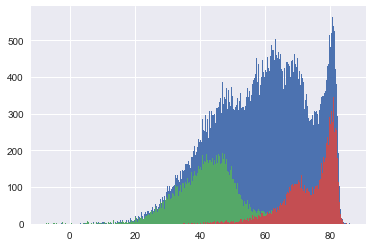

In [7]:
# 季節で傾向が違う。冬はまだしも、夏は地域差で峰も違う。
fig, axes = plt.subplots()
n, bins, patches = axes.hist(df["hukai_index"], bins=300) # 全体計
n, bins, patches = axes.hist(df_winter["hukai_index"], bins=300) # 冬
n, bins, patches = axes.hist(df_summer["hukai_index"], bins=300) # 夏

#### 予定していた方針を下記のように変更して、既知の分布に近くならないか確認する  

それでもダメそうだったらk近傍法を使う

  * 変更前：不快指数から外れ値を検出して、地域別に検出対象の日数を数える
  * 変更後：不快指数をビン化して該当日数を数え、該当日数から異常値を検出する


In [8]:
# 不快日数と快適日数を計算（55以下:寒くて不快, 80以上:暑くて不快, 65 - 70:快適）
df["is_hukai_cold"] = 0
df["is_hukai_cold"] = df["hukai_index"].apply(lambda x: int(x <= 55))
df["is_hukai_hot"] = 0
df["is_hukai_hot"] = df["hukai_index"].apply(lambda x: int(x > 80))
df["is_hukai"] = df[["is_hukai_cold", "is_hukai_hot"]].apply(lambda x: 1 - 0**(x[0] + x[1]), axis=1) # 同時に成立できないから普通に和でよかった

df["is_comfortable"] = 0
df["is_comfortable"] = df["hukai_index"].apply(lambda x: int((x > 65) & (x <= 70)))

df_hukai_cnt = df.groupby(["pref", "pref_sub", "area"], as_index=False).agg({"is_hukai_cold": np.sum, "is_hukai_hot": np.sum, "is_hukai": np.sum, "is_comfortable": np.sum})
df_hukai_cnt = df_hukai_cnt[:154] # 富士山が2回集計されていたので、まず重複を削除
df_hukai_cnt = df_hukai_cnt.drop(121) # 富士山はやっぱり外す

#### 年間不快日数と年間快適日数のヒストグラムを眺める　正規分布と言えなくもない感じ

正規分布から異常度を測定する方針に決定

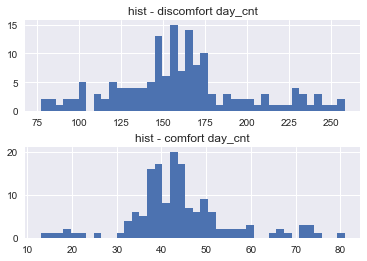

In [9]:
fig, axes = plt.subplots(2)
axes[0].set_title("hist - discomfort day_cnt")
axes[1].set_title("hist - comfort day_cnt")
plt.subplots_adjust(hspace=0.4)
n, bins, patches = axes[0].hist(df_hukai_cnt["is_hukai"], bins=40) # 不快ヒストグラム
n, bins, patches = axes[1].hist(df_hukai_cnt["is_comfortable"], bins=40) # 快適ヒストグラム

#### （確認）暑くて不快な日より、寒くて不快な日の方が多い

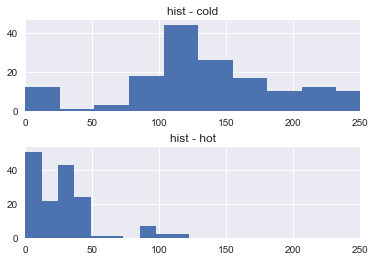

In [10]:
fig, axes = plt.subplots(2)
axes[0].set_xlim(0, 250)
axes[1].set_xlim(0, 250)
axes[0].set_title("hist - cold")
axes[1].set_title("hist - hot")
plt.subplots_adjust(hspace=0.4)
n, bins, patches = axes[0].hist(df_hukai_cnt["is_hukai_cold"]) # 寒い日ヒストグラム
n, bins, patches = axes[1].hist(df_hukai_cnt["is_hukai_hot"]) # 暑い日ヒストグラム

### 異常度を測定（ホテリングのT^2）
---

In [11]:
# 正規分布とみなして、パラメータを推定
mu_hat = df_hukai_cnt["is_hukai"].mean() # 異常度スコアを振る（不快）
sigma_hat = df_hukai_cnt["is_hukai"].std(ddof=0)

df_adj = df_hukai_cnt.copy()
df_adj["is_hukai"] = df_hukai_cnt["is_hukai"].apply(lambda x: x if x > mu_hat else mu_hat) # 快適な日（分布の左側）は検知しないように調整
df_adj = df_hukai_cnt

score = stats.norm.pdf(df_adj["is_hukai"], loc=mu_hat, scale=sigma_hat)
df_hukai_cnt["a_score"] = - np.log(score)
df_hukai_cnt["a_score_kai"] = ((df_adj["is_hukai"] - mu_hat) / sigma_hat) ** 2

mu_hat = df_hukai_cnt["is_comfortable"].mean() # 異常度スコアを振る（快適）
sigma_hat = df_hukai_cnt["is_comfortable"].std(ddof=0)

df_adj = df_hukai_cnt.copy()
df_adj["is_comfortable"] = df_hukai_cnt["is_comfortable"].apply(lambda x: x if x > mu_hat else mu_hat) # 不快な日（分布の左側）は検知しないように調整
df_adj = df_hukai_cnt

score = stats.norm.pdf(df_adj["is_comfortable"], loc=mu_hat, scale=sigma_hat)
df_hukai_cnt["a_score_comfort"] = - np.log(score)
df_hukai_cnt["a_score_comfort_kai"] = ((df_adj["is_comfortable"] - mu_hat) / sigma_hat) ** 2


#### カイ二乗スコアを表示（年間不快日数）

何かを検知している

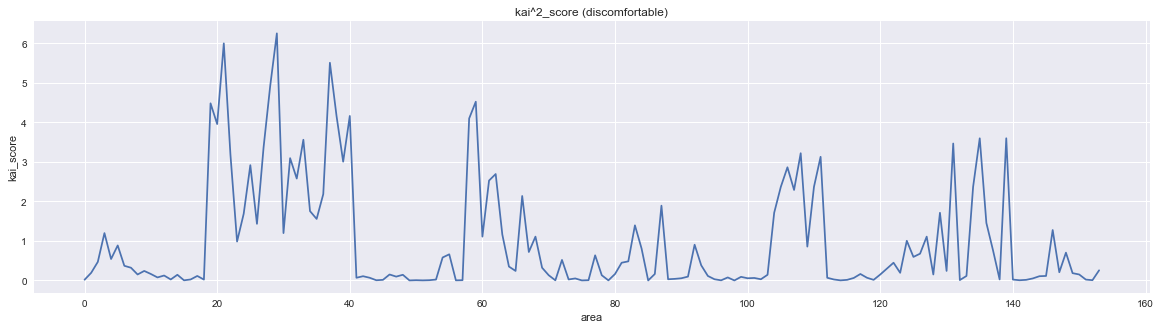

In [12]:
# カイ二乗スコアを表示（不快）
plt.figure(figsize=(20,5))
plt.title("kai^2_score (discomfortable)")
plt.plot(df_hukai_cnt["a_score_kai"])
plt.xlabel("area")
plt.ylabel("kai_score")
plt.show()

#### カイ二乗スコアを表示（年間快適日数）

こっちも何かを検知している

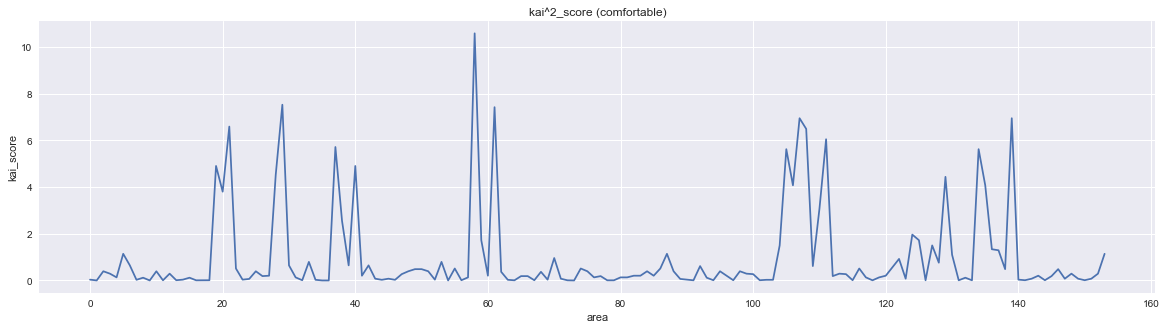

In [13]:
# カイ二乗スコアを表示（快適）
plt.figure(figsize=(20,5))
plt.title("kai^2_score (comfortable)")
plt.plot(df_hukai_cnt["a_score_comfort_kai"])
plt.xlabel("area")
plt.ylabel("kai_score")
plt.show()

In [14]:
df_very_discomfort = df_hukai_cnt.sort_values(by="a_score_kai", ascending=False)
df_very_comfort = df_hukai_cnt.sort_values(by="a_score_comfort_kai", ascending=False)

### 性能評価の方法と結果
---

カイ二乗分布の上側5%を異常と判定  
ノミネートされた地域に妥当性がありそうなので良しとした

#### 年間不快日数　の異常検知：北海道が上位を総なめしてる　大地が試されている

In [15]:
df_very_discomfort[df_very_discomfort["a_score_kai"] > 3.84]

,pref,pref_sub,area,is_hukai_cold,is_hukai_hot,is_hukai,is_comfortable,a_score,a_score_kai,a_score_comfort,a_score_comfort_kai
29,hokkaido_nemuro,根室,根室,258,0,258,13,7.712001,6.253147,7.110630,7.526712
21,hokkaido_abashiri,網走・北見・紋別,雄武,256,0,256,15,7.585446,6.000036,6.642323,6.590097
37,hokkaido_soya,宗谷,北見枝幸,252,0,252,17,7.340179,5.509502,6.205121,5.715693
28,hokkaido_kushiro,釧路,釧路,247,0,247,20,7.048301,4.925747,5.607640,4.520731
59,kagosima,鹿児島,屋久島,51,26,77,59,6.847130,4.523405,4.209198,1.723847
19,hokkaido_abashiri,網走・北見・紋別,紋別,243,0,243,19,6.826565,4.482274,5.799024,4.903499
38,hokkaido_soya,宗谷,稚内,240,0,240,26,6.667125,4.163395,4.622639,2.550730
40,hokkaido_tokachi,十勝,広尾,240,0,240,19,6.667125,4.163395,5.799024,4.903499
58,kagosima,鹿児島,名瀬,16,65,81,81,6.634861,4.098866,8.638246,10.581942
20,hokkaido_abashiri,網走・北見・紋別,網走,238,0,238,22,6.564100,3.957346,5.248201,3.801853


#### 年間快適日数　の異常検知：検知対象として島が上位へ　北海道もランクイン（快適日数が少な過ぎて検知）

In [464]:
df_very_comfort[df_very_comfort["a_score_comfort_kai"] > 3.84]

,pref,pref_sub,area,is_hukai_cold,is_hukai_hot,is_hukai,is_comfortable,a_score,a_score_kai,a_score_comfort,a_score_comfort_kai
58,kagosima,鹿児島,名瀬,16,65,81,81,6.634861,4.098866,8.638246,10.581942
29,hokkaido_nemuro,根室,根室,258,0,258,13,7.712001,6.253147,7.110630,7.526712
61,kagosima,鹿児島,沖永良部,8,90,98,75,5.849386,2.527917,7.057060,7.419571
139,tokyo,東京,父島,0,86,86,74,6.384230,3.597605,6.820746,6.946944
107,okinawa,沖縄,名護,6,95,101,74,5.730382,2.289908,6.820746,6.946944
21,hokkaido_abashiri,網走・北見・紋別,雄武,256,0,256,15,7.585446,6.000036,6.642323,6.590097
108,okinawa,沖縄,宮古島,2,88,90,73,6.195491,3.220126,6.592209,6.489869
111,okinawa,沖縄,那覇,2,89,91,72,6.149940,3.129024,6.371448,6.048346
37,hokkaido_soya,宗谷,北見枝幸,252,0,252,17,7.340179,5.509502,6.205121,5.715693
134,tokyo,東京,三宅島,70,30,100,71,5.769396,2.367937,6.158463,5.622377


### 構築した異常検知モデルの社会的意義
---

  * 何らかの都合で該当地域へ引っ越す際に、**覚悟と準備** をする目安になる  
  * 不快な気候が続くとつらいので、社会保障の予算増やしてもいいと思う

#### 異常検知された地域を、地図上へ表示

  * <font color="darkblue">青: 不快な日が多く、快適な日数が少ない</font>
  * <font color="blue">青: 不快な日が多い</font>
  * <font color="darkgreen">緑: 不快な日が少ない or 快適な日が多い</font>
  * <font color="DarkKhaki ">黄: 不快な日が少なく、快適な日が多い（最強）</font>

In [30]:
import folium
jp_map = folium.Map(location=[38.3, 137.7], zoom_start=5) # とりあえず焦点を日本の中心へ

# 不快日数が多く、快適日数が少ない
folium.Marker([43.330076, 145.58279], popup='根室', icon=folium.Icon(color='darkblue', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([44.582551, 142.96181], popup='雄武（おうむ）', icon=folium.Icon(color='darkblue', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([44.938714, 142.581411], popup='北見枝幸（きたみえさし）', icon=folium.Icon(color='darkblue', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([42.984854, 144.381356], popup='釧路', icon=folium.Icon(color='darkblue', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([44.356484, 143.354503], popup='紋別', icon=folium.Icon(color='darkblue', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([42.285838, 143.311496], popup='広尾', icon=folium.Icon(color='darkblue', icon="circle", prefix="fa")).add_to(jp_map)

# 不快日数が多い
folium.Marker([45.415664, 141.673082], popup='稚内（わっかない）', icon=folium.Icon(color='blue', icon="circle", prefix="fa")).add_to(jp_map) # 以下、北海道略
folium.Marker([44.020632, 144.273398], popup='網走', icon=folium.Icon(color='blue', icon="circle", prefix="fa")).add_to(jp_map) # 以下、北海道略

# 不快日数が少ない
folium.Marker([30.344594, 130.512714], popup='屋久島', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)

# 快適日数が多い
folium.Marker([27.366219, 128.600533], popup='沖永良部', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([27.075053, 142.211603], popup='父島', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([26.591547, 127.977316], popup='名護', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([24.80549, 125.281149], popup='宮古島', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([26.212312, 127.679157], popup='那覇', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([34.090927, 139.524921], popup='三宅島', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([26.350396, 126.771177], popup='久米島', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([35.734681, 140.826641], popup='銚子（ちょうし、千葉）', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([33.103021, 139.803557], popup='八丈島', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)
folium.Marker([25.848778, 131.250733], popup='南大東（南大東島）', icon=folium.Icon(color='green', icon="circle", prefix="fa")).add_to(jp_map)

# 不快日数が少なく、快適日数が多い
folium.Marker([28.37, 129.48], popup='名瀬', icon=folium.Icon(color='beige', icon="circle", prefix="fa")).add_to(jp_map)

# その他 
folium.Marker([35.360556, 138.727778], popup='富士山　365日寒い', icon=folium.Icon(color='lightgray', icon="circle", prefix="fa")).add_to(jp_map) # 365日寒い
folium.Marker([36.719903, 139.698216], popup='奥日光（栃木） 北海道を除外すると不快1位', icon=folium.Icon(color='lightgray', icon="circle", prefix="fa")).add_to(jp_map) # 北海道を除くと、不快日数1位 ギリギリ入らず


#### まとめ

  * 年間不快日数（とても少ない） + 年間快適日数（とても多い） で検知された、鹿児島県名瀬市が2018年ベスト気候地域
  * 北海道の中でも、海岸沿いが特に寒い
  * 本州の中では唯一、千葉県銚子市が年間快適日数で検知された（快適な日が多い）

In [36]:
jp_map

### 通し課題に取り組んだ感想
---

  * 「社会的に意義があるテーマ」を設定することがとてもつらかった
  * 外れ値（富士山）を含むか含まないか、異常値が学習データに含まれるか含まれないか、で学習結果が結構変わることを体感できた
  * 既知の分布で話が付くなら、それに持ち込んだ方が早いことも体感できた  
  * せっかくなのでもう少し複雑な手法を使ってみたかった気持ちは残る

#### （付録）富士山を含めて異常スコアを計算すると、富士山が大差で圧勝する

学習に異常データが含まれると、それに引っ張られる  
カイ二乗スコアも当然変わる

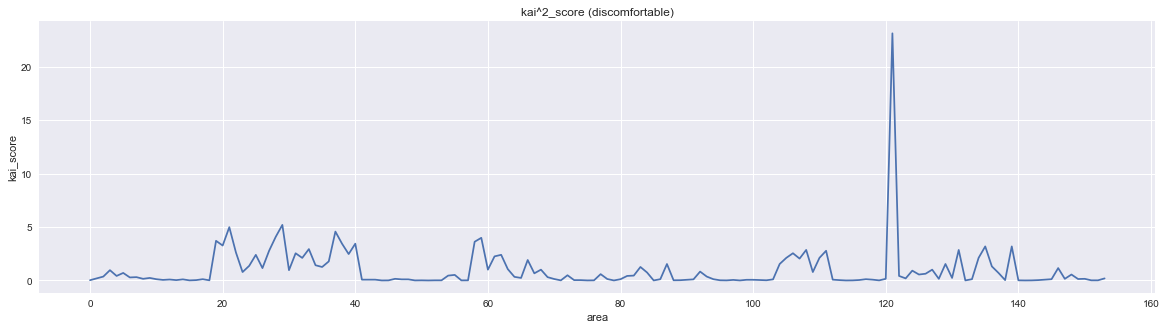

In [438]:
# 不快日数と快適日数を計算（55以下:寒くて不快, 80以上:暑くて不快, 65 - 70:快適）
df_hukai_cnt = df.groupby(["pref", "pref_sub", "area"], as_index=False).agg({"is_hukai_cold": np.sum, "is_hukai_hot": np.sum, "is_hukai": np.sum, "is_comfortable": np.sum})
df_hukai_cnt = df_hukai_cnt[:154] # 特定エリアが2回集計されていたので重複を削除

# 正規分布とみなして、パラメータを推定
mu_hat = df_hukai_cnt["is_hukai"].mean() # 異常度スコアを振る（不快）
sigma_hat = df_hukai_cnt["is_hukai"].std(ddof=0)
df_adj = df_hukai_cnt.copy()

df_adj["is_hukai"] = df_hukai_cnt["is_hukai"].apply(lambda x: x if x > mu_hat else mu_hat) # 快適な日（分布の左側）は検知しないように調整
df_adj = df_hukai_cnt

score = stats.norm.pdf(df_adj["is_hukai"], loc=mu_hat, scale=sigma_hat)
df_hukai_cnt["a_score"] = - np.log(score)
df_hukai_cnt["a_score_kai"] = ((df_adj["is_hukai"] - mu_hat) / sigma_hat) ** 2

mu_hat = df_hukai_cnt["is_comfortable"].mean() # 異常度スコアを振る（快適）
sigma_hat = df_hukai_cnt["is_comfortable"].std(ddof=0)

df_adj = df_hukai_cnt.copy()
df_adj["is_comfortable"] = df_hukai_cnt["is_comfortable"].apply(lambda x: x if x > mu_hat else mu_hat) # 不快な日（分布の左側）は検知しないように調整

score = stats.norm.pdf(df_adj["is_comfortable"], loc=mu_hat, scale=sigma_hat)
df_hukai_cnt["a_score_comfort"] = - np.log(score)
df_hukai_cnt["a_score_comfort_kai"] = ((df_adj["is_comfortable"] - mu_hat) / sigma_hat) ** 2

# カイ二乗スコアを表示（不快）
plt.figure(figsize=(20,5))
plt.title("kai^2_score (discomfortable)")
plt.plot(df_hukai_cnt["a_score_kai"])
plt.xlabel("area")
plt.ylabel("kai_score")
plt.show()

In [37]:
# 富士山は毎日寒い
df_hukai_cnt[121:122]

,pref,pref_sub,area,is_hukai_cold,is_hukai_hot,is_hukai,is_comfortable,a_score,a_score_kai,a_score_comfort,a_score_comfort_kai
122,sizuoka,静岡,御前崎,98,36,134,55,4.809585,0.448316,3.808286,0.922022
